In [2]:
# Load required packages
import pandas as pd
import re
import glob
import xml.etree.ElementTree as ET


In [3]:
# using glob package to open multiple files at once
file_pattern = 'review_*.txt'
file_names = glob.glob(file_pattern)
file_names.sort()

In [4]:
rev_id = []
prod_id = []
rev_name = []
no_help = []
rev_date  = []
rev_text = []
summary = []

# define regex pattern
rev_id_pattern = r"^\$(rev|reviewer)[id_.\:]+\s[A-Z0-9]+$"
prod_id_pattern = r"^\$(prod|product)[id_.\:]+\s[A-Z0-9]+$"
rev_name_pattern = r"^\$(rev|reviewer)[name_.:]+\s.*$"
no_help_pattern = r"^\$(helps|Helpful|No\. helps)[.\?_]+:\s[\[0-9\,\s\]]+"
date_pattern = r"\$(reviewDate|review_date)[.:]+\s(?:[0-1][0-9]\s[0-9]+\,\s[2][0][0-2][0-9])+"
text_pattern = r"\$(?:REVIEW|review)[text_.:]+\s([\s\S]*?)(?=\$\w+\.:)"
summary_pattern = r"\$(?:review_summary|SUMMARY)[.:]+\s([\s\S]*?)(?=\$(?:rev|[a-zA-Z])\w+|$)"


In [5]:
for reviews in file_names:
    with open (reviews, "r") as file:
        file_content = file.read()
        # Exrtract multiline texts and summaries from the entire file content
        rev_text.extend(re.findall(text_pattern, file_content))
        summary.extend(re.findall(summary_pattern, file_content))

        # Reset file pointer to start for line-by-line processing
        file.seek(0)

        for line in file:
            line = line.strip()
            match_rev_id = re.search(rev_id_pattern, line, re.IGNORECASE)
            match_prod_id = re.search(prod_id_pattern, line, re.IGNORECASE)
            match_rev_name = re.search(rev_name_pattern, line, re.IGNORECASE)
            match_helpful = re.search(no_help_pattern, line)
            match_date = re.search(date_pattern, line)
            match_texts = re.findall(text_pattern, line) # [4]
            match_summary = re.findall(summary_pattern, line)

            if match_rev_id:
                id_match = match_rev_id.group().strip()
                match_id = re.search(r"[A-Z0-9]+$", id_match)
                if match_id:
                    actual_id = match_id.group()
                    rev_id.append(actual_id)
                    
            if match_prod_id:
                prod_match = match_prod_id.group(0).strip()
                match_prod = re.search(r"[A-Z0-9]+$", prod_match)
                if match_prod:
                    actual_prod = match_prod.group()
                    prod_id.append(actual_prod)

            if match_rev_name:
                name_match = match_rev_name.group().strip()
                match_name = re.search(r"\s.*$", name_match)
                if match_name:
                    actual_name = match_name.group(0)
                    rev_name.append(actual_name)

            if match_helpful:
                help_match = match_helpful.group().strip()
                match_help = re.search(r"\s[\[0-9\,\s\]]+", help_match)
                if match_help:
                    actual_help = match_help.group()
                    no_help.append(actual_help)
            
            if match_date:
                date_match = match_date.group()
                match_date_value = re.search(r"(?:[0-1][0-9]\s[0-9]+\,\s[2][0][0-2][0-9])+", date_match)
                if match_date_value:
                    actual_date = match_date_value.group()
                    rev_date.append(actual_date)


In [6]:
rev_text[0]

"This card works as expected, was delivered fast and for a great price. The card doesn't run much but as long as i got picture i was happy!\n"

In [7]:
revid_df = pd.DataFrame({'reviewer_id': rev_id})
name_df = pd.DataFrame({'reviewer_name': rev_name})
prod_df = pd.DataFrame({'productID': prod_id})
help_df = pd.DataFrame({'review_helpful': no_help})
date_df = pd.DataFrame({'Date': rev_date})
text_df = pd.DataFrame({'review_text': rev_text})
text_df["review_text"] = text_df["review_text"].str.strip()
summary_df = pd.DataFrame({'review_summary': summary})
summary_df["review_summary"] = summary_df["review_summary"].str.strip()
combine_df = pd.concat([revid_df, name_df, prod_df, help_df, date_df, text_df, summary_df], axis=1)

In [8]:
# test
print(combine_df.head()) # printing out the first 5 and last 5 to determine each row is unique (right information)
print(combine_df.tail())

      reviewer_id                  reviewer_name   productID review_helpful  \
0  A1BWD4UA5QTBOI                    Edward Popp  B004BQKQ8A         [0, 0]   
1  A27JB8ALUWAECO                 Hector M. Lugo  B005O74J7O         [0, 0]   
2  A32B6A532454UD   D. Taylor "Tech Gadget User"  B005P9CATU       [10, 10]   
3  A225M3GAYN01IG                     buster_roo  B0023APPCI         [1, 1]   
4   AX2F72W2O86WI                           Alyx  B0055LGG3Y         [3, 4]   

          Date                                        review_text  \
0  10 28, 2013  This card works as expected, was delivered fas...   
1  01 16, 2014  Well, as cases go, this one looks good on the ...   
2  06 12, 2012  I've been using these APP or Anderson Power Po...   
3  04 10, 2011  I have this model.  I use it with my Vizio LED...   
4   06 7, 2012  If you're building a system using SandyBridge ...   

                                      review_summary  
0                 Bought this for an older computer.  


In [9]:

def xml_characters(text): # function to deal with xml characters
    return re.sub(r'[<>&\'"]', ' ', text) 

root = ET.Element("users") # root node

for index, row in combine_df.iterrows():
    # Create user element with name attribute
    user_element = ET.SubElement(root, "user")
    user_element.set("name", row['reviewer_id'])

    # Add latest_review_date under user element
    ET.SubElement(user_element, 'latest_review_date').text = row['Date']

    # Create reviews element under user element
    reviews_element = ET.SubElement(user_element, 'reviews')

    # Create review element under reviews element
    review_element = ET.SubElement(reviews_element, 'review')

    # Add subelements under review element
    ET.SubElement(review_element, 'productID').text = row['productID']
    ET.SubElement(review_element, 'review_date').text = row['Date']
    ET.SubElement(review_element, 'review_helpful').text = str(row['review_helpful'])  # Assuming this is not a string

    # Handling XML characters for review text and summary
    review_text = xml_characters(row['review_text'])
    review_summary = xml_characters(row['review_summary'])

    # Add review_text and review_summary under review element
    ET.SubElement(review_element, 'review_text').text = review_text
    ET.SubElement(review_element, 'review_summary').text = review_summary

# Create and write the XML tree
tree = ET.ElementTree(root)
tree.write('review.xml') # output file save

Text preprocessing for semantic analysis. 

In [10]:
# Parsing the XML file based on its structure
import xml.etree.ElementTree as etree    
file_path = 'review.xml'

# Define a function to parse and extract data from the XML
def parse_xml(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()

    # Create a list to store all review data
    reviews_data = []

    # Iterate through each user in the XML
    for user in root.findall('user'):
        user_name = user.get('name')
        latest_review_date = user.find('latest_review_date').text if user.find('latest_review_date') is not None else None
        
        # Iterate through each review of the user
        for review in user.find('reviews'):
            product_id = review.find('productID').text if review.find('productID') is not None else None
            review_date = review.find('review_date').text if review.find('review_date') is not None else None
            review_helpful = review.find('review_helpful').text if review.find('review_helpful') is not None else None
            review_text = review.find('review_text').text if review.find('review_text') is not None else None
            review_summary = review.find('review_summary').text if review.find('review_summary') is not None else None

            # Append the data to the list
            reviews_data.append({
                "userID": user_name,
                "review_date": latest_review_date,
                "productID": product_id,
                "review_helpful": review_helpful,
                "review_text": review_text,
                "review_summary": review_summary
            })

    # Convert the list to a DataFrame
    return pd.DataFrame(reviews_data)

# Parse the XML and create a DataFrame
review_df = parse_xml(file_path)
review_df.head()


,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,"10 28, 2013",B004BQKQ8A,"[0, 0]","This card works as expected, was delivered fas...",Bought this for an older computer.
1,A27JB8ALUWAECO,"01 16, 2014",B005O74J7O,"[0, 0]","Well, as cases go, this one looks good on the ...","No, just no!"
2,A32B6A532454UD,"06 12, 2012",B005P9CATU,"[10, 10]",I ve been using these APP or Anderson Power Po...,"Reliable connector, considered standard in Ham..."
3,A225M3GAYN01IG,"04 10, 2011",B0023APPCI,"[1, 1]",I have this model. I use it with my Vizio LED...,"great sound, easy set up, looks amazing"
4,AX2F72W2O86WI,"06 7, 2012",B0055LGG3Y,"[3, 4]",If you re building a system using SandyBridge ...,Great Memory


In [11]:
# Mutate date format
review_df['review_date'] = pd.to_datetime(review_df['review_date'])
# review_df['review_date'] = review_df['review_date'].dt.strftime('%Y%m%d').astype(int)
review_df['review_text'] = review_df['review_text'].str.lower()
review_df['review_summary'] = review_df['review_summary'].str.lower()
review_df.head()  

,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]","this card works as expected, was delivered fas...",bought this for an older computer.
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]","well, as cases go, this one looks good on the ...","no, just no!"
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]",i ve been using these app or anderson power po...,"reliable connector, considered standard in ham..."
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]",i have this model. i use it with my vizio led...,"great sound, easy set up, looks amazing"
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]",if you re building a system using sandybridge ...,great memory


In [11]:
import string
string.punctuation
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
review_df['review_text']= review_df['review_text'].apply(lambda x:remove_punctuation(x))
review_df['review_summary']= review_df['review_summary'].apply(lambda x:remove_punctuation(x))
review_df.head()

,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]",this card works as expected was delivered fast...,bought this for an older computer
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]",well as cases go this one looks good on the ta...,no just no
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]",i ve been using these app or anderson power po...,reliable connector considered standard in ham ...
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]",i have this model i use it with my vizio led ...,great sound easy set up looks amazing
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]",if you re building a system using sandybridge ...,great memory


In [12]:
#importing nlp library
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

review_df['review_text'] = review_df['review_text'].apply(word_tokenize)
eng_stopwords = stopwords.words('english') 
review_df['review_text'] = review_df['review_text'].apply(lambda words: [word for word in words if word not in eng_stopwords])
review_df['review_summary'] = review_df['review_summary'].apply(word_tokenize)
review_df['review_summary'] = review_df['review_summary'].apply(lambda words: [word for word in words if word not in eng_stopwords])
review_df.head()

,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]","[card, works, expected, delivered, fast, great...","[bought, older, computer]"
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]","[well, cases, go, one, looks, good, tablet, fe...",[]
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]","[using, app, anderson, power, pole, connectors...","[reliable, connector, considered, standard, ha..."
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]","[model, use, vizio, led, hd, tv, vizion, blura...","[great, sound, easy, set, looks, amazing]"
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]","[building, system, using, sandybridge, intel, ...","[great, memory]"


In [13]:
review_lemm = review_df.copy()
review_lemm.head()

,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]","[card, works, expected, delivered, fast, great...","[bought, older, computer]"
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]","[well, cases, go, one, looks, good, tablet, fe...",[]
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]","[using, app, anderson, power, pole, connectors...","[reliable, connector, considered, standard, ha..."
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]","[model, use, vizio, led, hd, tv, vizion, blura...","[great, sound, easy, set, looks, amazing]"
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]","[building, system, using, sandybridge, intel, ...","[great, memory]"


In [14]:
from nltk.stem import WordNetLemmatizer
#defining the object for Lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(word_list):
    return [lemmatizer.lemmatize(w) for w in word_list]

# Apply the revised function to the 'review_text' column
review_lemm['review_text'] = review_lemm['review_text'].apply(lemmatize_text)
review_lemm['review_summary'] = review_lemm['review_summary'].apply(lemmatize_text)
review_lemm.head()

,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]","[card, work, expected, delivered, fast, great,...","[bought, older, computer]"
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]","[well, case, go, one, look, good, tablet, feel...",[]
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]","[using, app, anderson, power, pole, connector,...","[reliable, connector, considered, standard, ha..."
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]","[model, use, vizio, led, hd, tv, vizion, blura...","[great, sound, easy, set, look, amazing]"
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]","[building, system, using, sandybridge, intel, ...","[great, memory]"


In [15]:
review_text_cv = review_lemm['review_text'].astype(str)


from nltk.tokenize import RegexpTokenizer 
tokenizer = RegexpTokenizer(r"[A-Za-z]\w+(?:[-'?]\w+)?")
unigram = []

for abstract in review_text_cv:
    unigram_tokens = tokenizer.tokenize(abstract)
    unigram.append(unigram_tokens)


In [16]:
unigram[0]

['card',
 'work',
 'expected',
 'delivered',
 'fast',
 'great',
 'price',
 'card',
 'run',
 'much',
 'long',
 'got',
 'picture',
 'happy']

In [17]:
from itertools import chain # this is to combine the lists into single list
words = list(chain.from_iterable(unigram)) # raw token version 

In [18]:
words[:10]

['card',
 'work',
 'expected',
 'delivered',
 'fast',
 'great',
 'price',
 'card',
 'run',
 'much']

In [19]:
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import matplotlib as p
fd_1 = FreqDist() 
for freq_token in unigram:
    fd_1.update(freq_token)
print(fd_1.most_common(100))

[('one', 5010), ('work', 4410), ('use', 4137), ('great', 3834), ('good', 3683), ('like', 3570), ('get', 3378), ('would', 3213), ('camera', 2912), ('well', 2795), ('case', 2563), ('time', 2535), ('cable', 2423), ('sound', 2416), ('also', 2257), ('quality', 2256), ('product', 2124), ('really', 2118), ('need', 2097), ('price', 2086), ('battery', 2084), ('much', 2035), ('drive', 2019), ('even', 1885), ('using', 1855), ('make', 1804), ('device', 1786), ('better', 1754), ('problem', 1750), ('tv', 1715), ('thing', 1712), ('bought', 1712), ('little', 1706), ('used', 1703), ('easy', 1617), ('card', 1570), ('screen', 1547), ('usb', 1527), ('back', 1491), ('want', 1490), ('nice', 1463), ('look', 1454), ('still', 1450), ('lens', 1436), ('computer', 1422), ('fit', 1421), ('go', 1418), ('could', 1405), ('buy', 1382), ('new', 1348), ('got', 1341), ('unit', 1329), ('power', 1326), ('set', 1324), ('two', 1322), ('video', 1279), ('way', 1252), ('first', 1244), ('year', 1240), ('take', 1237), ('speaker',

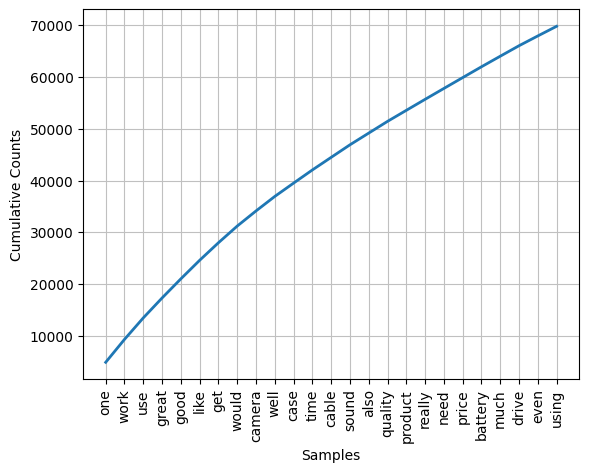

<Axes: xlabel='Samples', ylabel='Cumulative Counts'>

In [20]:
fd_1.plot(25, cumulative=True)

In [21]:
least_common = fd_1.most_common()[-50:]
print(least_common) # least common [5] 

[('locationsin', 1), ('equator', 1), ('videoandsoundconnect', 1), ('spaciousa', 1), ('amp1', 1), ('ouput', 1), ('preamped', 1), ('converter2', 1), ('two3', 1), ('desktop5', 1), ('once5', 1), ('howeverit', 1), ('psb', 1), ('alpa', 1), ('setup7', 1), ('emu', 1), ('a1100ishoping', 1), ('timedefinitely', 1), ('sienna', 1), ('gta5', 1), ('grave', 1), ('mytimbuk2', 1), ('tastemy', 1), ('howeversome', 1), ('peoplesome', 1), ('chocolate', 1), ('unklnown', 1), ('showrooming', 1), ('twobefore', 1), ('lightindoor', 1), ('shotsbuy', 1), ('dpods', 1), ('atp', 1), ('promax', 1), ('expectedi', 1), ('crapwear', 1), ('platformsvideo', 1), ('okmy', 1), ('itaccessories', 1), ('mm250mm', 1), ('addonnight', 1), ('amazinglearned', 1), ('focusall', 1), ('entertainer', 1), ('runaround', 1), ('workingacid', 1), ('websitemovie', 1), ('tooli', 1), ('audioconscious', 1), ('impulsively', 1)]


In [22]:
review_updated = review_lemm.copy()

In [23]:
total_count = len(review_lemm)
rare_tokensSet = set()
less3_tokensSet = set()

for token, count in fd_1.items():
    frequency = count / total_count
    if frequency < 0.02:
        rare_tokensSet.add(token)
    elif frequency < 3:
        less3_tokensSet.add(token)

review_updated['review_text'] = review_updated['review_text'].apply(lambda x: [w for w in x if w not in rare_tokensSet])
review_updated['review_summary'] = review_updated['review_summary'].apply(lambda x: [w for w in x if w not in rare_tokensSet])

In [26]:
review_lemm.head()

,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]","[card, work, expected, delivered, fast, great,...","[bought, older, computer]"
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]","[well, case, go, one, look, good, tablet, feel...",[]
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]","[using, app, anderson, power, pole, connector,...","[reliable, connector, considered, standard, ha..."
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]","[model, use, vizio, led, hd, tv, vizion, blura...","[great, sound, easy, set, look, amazing]"
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]","[building, system, using, sandybridge, intel, ...","[great, memory]"


In [27]:
review_updated.head()

,userID,review_date,productID,review_helpful,review_text,review_summary
0,A1BWD4UA5QTBOI,2013-10-28,B004BQKQ8A,"[0, 0]","[card, work, expected, fast, great, price, car...","[bought, older, computer]"
1,A27JB8ALUWAECO,2014-01-16,B005O74J7O,"[0, 0]","[well, case, go, one, look, good, tablet, feel...",[]
2,A32B6A532454UD,2012-06-12,B005P9CATU,"[10, 10]","[using, app, power, connector, year, couple, d...","[connector, standard, radio, us, 30, amp]"
3,A225M3GAYN01IG,2011-04-10,B0023APPCI,"[1, 1]","[model, use, led, hd, tv, bluray, amazing, sou...","[great, sound, easy, set, look, amazing]"
4,AX2F72W2O86WI,2012-06-07,B0055LGG3Y,"[3, 4]","[system, using, memory, system, purchased, mem...","[great, memory]"


In [32]:
review_updated.to_csv("amazon-customer-reviews.csv", index = False)